In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import numpy as np
from random import randint
import keras
from keras.datasets import mnist
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.layers import Input, Reshape, Dense, Conv2D, Dropout, \
    MaxPooling2D, Flatten, UpSampling2D, Multiply, Activation, AveragePooling2D, \
    Add, Subtract, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.ndimage import gaussian_filter as blur
from keras.optimizers import Adam
from keras.utils import multi_gpu_model as mgpu
from keras.utils import np_utils
import os, sys

Using TensorFlow backend.


In [33]:
imsize = 64
encspec = [
    [128],
    [128, 128], # 128
    [256, 256, 256, 256], # 64
    [256, 256, 256, 256], # 64
#     [256, 256, 256], # 32
    [512, 512, 512, 512],# 16
#     [512, 512, 512], # 8
] # 4
poolspec = [ True, True, True, True, False ]

print('Conv Spec:')
dynsize = imsize
for lii,layerspec in enumerate(encspec):
    tosize = dynsize//2 if poolspec[lii] else dynsize
    if tosize % 2 == 1: tosize += 1
    print('%d => %d: %s' % (dynsize, tosize, layerspec))
    dynsize = tosize


Conv Spec:
64 => 32: [128]
32 => 16: [128, 128]
16 => 8: [256, 256, 256, 256]
8 => 4: [256, 256, 256, 256]
4 => 4: [512, 512, 512, 512]


In [34]:

model = Sequential()
# NOTE: Initial layers needs an input_shape...
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', 
                 input_shape=(imsize, imsize, 1)))
for lii, layerspec in enumerate(encspec):
    for nFilters in layerspec:
        model.add(Conv2D(nFilters, (3, 3), padding='same', activation='relu'))
    if poolspec[lii]:
        model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same')) # = 14
# always do additional conv after final maxpool
# for ii in range(4):
#     model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    
model.add(Reshape((dynsize * dynsize * 512,)))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))


In [36]:
opt = Adam(0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
print(K.eval(model.optimizer.lr))

1e-04


In [18]:
nb_classes = 10
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# X_train = X_train.reshape(60000, 784)
# X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)
Training matrix shape (60000, 28, 28)
Testing matrix shape (10000, 28, 28)


In [19]:
Y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [37]:
import cv2
bsize = 64

def resize(img, to=64):
    scale = to / img.shape[0]
    return cv2.resize(img, (0,0), fx=scale, fy=scale)

def datagen():
    while True:
        for b0 in range(0, len(X_train), bsize):
            batch_imgs = X_train[b0:b0+bsize]
            batch_lbls = Y_train[b0:b0+bsize]
            if len(batch_lbls) < bsize: continue
            batch_imgs = [resize(img, imsize) for img in batch_imgs]
            batch_imgs = np.array(batch_imgs).reshape((bsize, imsize, imsize, 1))
    #         assert batch_imgs[0].shape == (64, 64, 1)
            yield batch_imgs, batch_lbls
        
print(type(datagen()))

<class 'generator'>


In [38]:
hist = model.fit_generator(
    datagen(),
    epochs=4,
    verbose=1,
    steps_per_epoch=len(X_train)//bsize-1
#           validation_data=(X_test, Y_test)
)

Epoch 1/4
936/936 [==============================] - 76s 81ms/step - loss: 0.2378 - acc: 0.9226
Epoch 2/4
380/936 [===========>..................] - ETA: 43s - loss: 0.0784 - acc: 0.9775

KeyboardInterrupt: 

In [39]:
eval = X_test[:bsize]
eval = [resize(img, to=imsize) for img in eval]
eval = np.array(eval).reshape((bsize, imsize, imsize, 1))
ypreds = model.predict(eval)

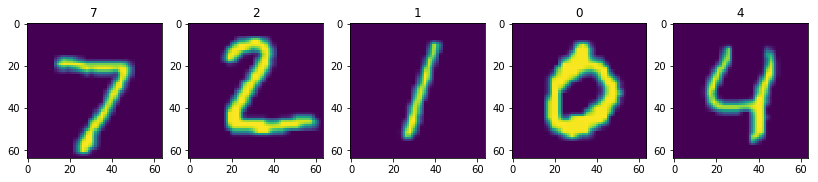

In [40]:
plt.figure(figsize=(14,5))
for ii in range(5):
    plt.subplot(1, 5, ii+1)
    plt.gca().set_title(np.argmax(ypreds[ii]))
    plt.imshow(eval[ii, :, :, 0])
plt.show()
plt.close()
    